In [ ]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 91.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:
Train_df = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training'

filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 1457/1457 [00:00<00:00, 611538.17it/s]


In [ ]:
df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)
df_train.head()

,filepath,label
0,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
1,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
2,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
3,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
4,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma


In [ ]:
Test_df = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing'

filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 300/300 [00:00<00:00, 392725.09it/s]


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1"
image_size = (256, 256)
batch_size = 8

In [ ]:
df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)
df_test.head()

,filepath,label
0,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
1,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
2,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
3,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
4,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma


In [ ]:
valid_ts, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [ ]:
tr_gen = ImageDataGenerator(rescale=1/255)
ts_gen = ImageDataGenerator(rescale=1/255)
batchsize = 32
img_size = (224,224)
gen_train = tr_gen.flow_from_dataframe(df_train, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_valid = ts_gen.flow_from_dataframe(valid_ts, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_test = ts_gen.flow_from_dataframe(df_test, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=False ,color_mode='rgb')
class_dict = gen_train.class_indices

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])
history = model.fit(
    gen_train,
    epochs=64,
    validation_data=gen_valid,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/64
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 552ms/step - accuracy: 0.5934 - loss: 1.1793 - precision: 0.6372 - recall: 0.5383 - val_accuracy: 0.2305 - val_loss: 3.8394 - val_precision: 0.2305 - val_recall: 0.2305
Epoch 2/64
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 353ms/step - accuracy: 0.8194 - loss: 0.5307 - precision: 0.8401 - recall: 0.7839 - val_accuracy: 0.4244 - val_loss: 1.9546 - val_precision: 0.4669 - val_recall: 0.3771
Epoch 3/64
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 357ms/step - accuracy: 0.8594 - loss: 0.3937 - precision: 0.8767 - recall: 0.8435 - val_accuracy: 0.7634 - val_loss: 0.5924 - val_precision: 0.7863 - val_recall: 0.7191
Epoch 4/64
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 361ms/step - accuracy: 0.8952 - loss: 0.3086 - precision: 0.9046 - recall: 0.8829 - val_accuracy: 0.8061 - val_loss: 0.4665 - val_precision: 0.8407 - val_recall: 0.7893
Epoch 5/64
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 361ms/step - accuracy: 0.9110 - loss: 0.2665 - precision: 0.9186 - recall: 0.9004 - val_accuracy: 0.887

In [ ]:
model.save('mri2.h5')

In [ ]:
print(model.evaluate(gen_train))
print(model.evaluate(gen_valid))
print(model.evaluate(gen_test))

179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.9988 - loss: 0.0037 - precision: 0.9988 - recall: 0.9988
[0.0033792590256780386, 0.9989495873451233, 0.9991244673728943, 0.9989495873451233]
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9838 - loss: 0.0451 - precision: 0.9838 - recall: 0.9838
[0.03910118713974953, 0.9847328066825867, 0.9847328066825867, 0.9847328066825867]
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9837 - loss: 0.0346 - precision: 0.9837 - recall: 0.9837
[0.026108508929610252, 0.9878048896789551, 0.9878048896789551, 0.9878048896789551]


In [ ]:
preds = model.predict(gen_test)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step


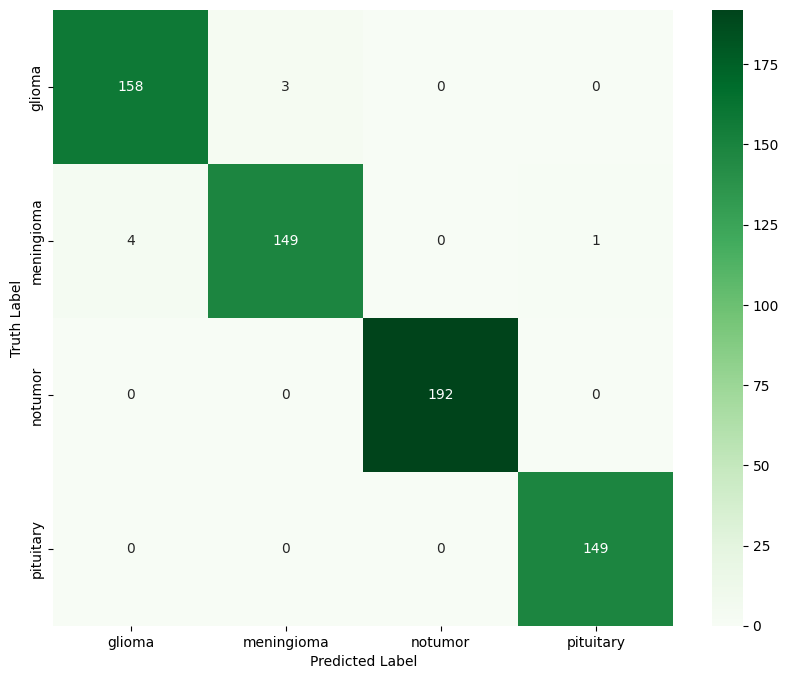

In [ ]:
cm = confusion_matrix(gen_test.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

[0.6901260614395142, 0.8214285969734192, 0.8588935732841492, 0.8939075469970703, 0.9047619104385376, 0.9219187498092651, 0.9325980544090271, 0.9403011202812195, 0.9457283020019531, 0.9571078419685364, 0.9588585495948792, 0.9663865566253662, 0.975665271282196, 0.9740896224975586, 0.9795168042182922, 0.9851190447807312, 0.9870448112487793, 0.9788165092468262, 0.981792688369751, 0.9903711676597595, 0.9851190447807312, 0.9882702827453613, 0.9952731132507324, 0.9924719929695129, 0.9886204600334167, 0.9954481720924377, 0.9908963441848755, 0.9910714030265808, 0.9975489974021912, 0.9956232309341431, 0.9929971694946289, 0.9980742335319519, 0.9991246461868286, 0.9961484670639038, 0.9978991746902466, 0.9961484670639038, 0.9928221106529236, 0.9942227005958557, 0.9968487620353699, 0.9991246461868286]


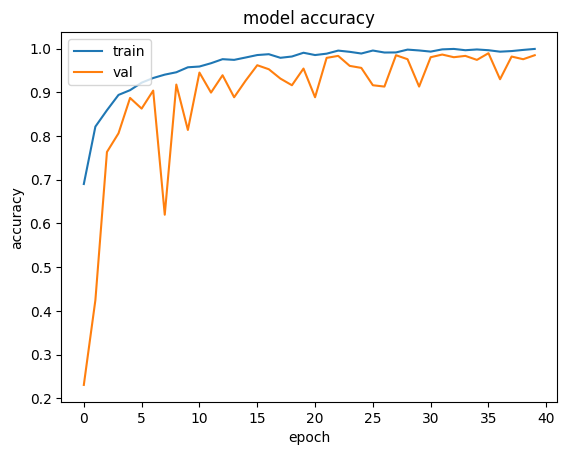

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
print(history.history['accuracy'])

In [ ]:
print(history.history['accuracy'])

[0.6901260614395142, 0.8214285969734192, 0.8588935732841492, 0.8939075469970703, 0.9047619104385376, 0.9219187498092651, 0.9325980544090271, 0.9403011202812195, 0.9457283020019531, 0.9571078419685364, 0.9588585495948792, 0.9663865566253662, 0.975665271282196, 0.9740896224975586, 0.9795168042182922, 0.9851190447807312, 0.9870448112487793, 0.9788165092468262, 0.981792688369751, 0.9903711676597595, 0.9851190447807312, 0.9882702827453613, 0.9952731132507324, 0.9924719929695129, 0.9886204600334167, 0.9954481720924377, 0.9908963441848755, 0.9910714030265808, 0.9975489974021912, 0.9956232309341431, 0.9929971694946289, 0.9980742335319519, 0.9991246461868286, 0.9961484670639038, 0.9978991746902466, 0.9961484670639038, 0.9928221106529236, 0.9942227005958557, 0.9968487620353699, 0.9991246461868286]


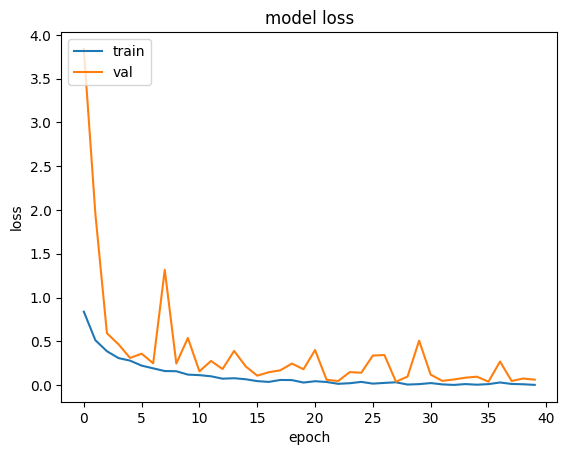

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
def predict(img_path):
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


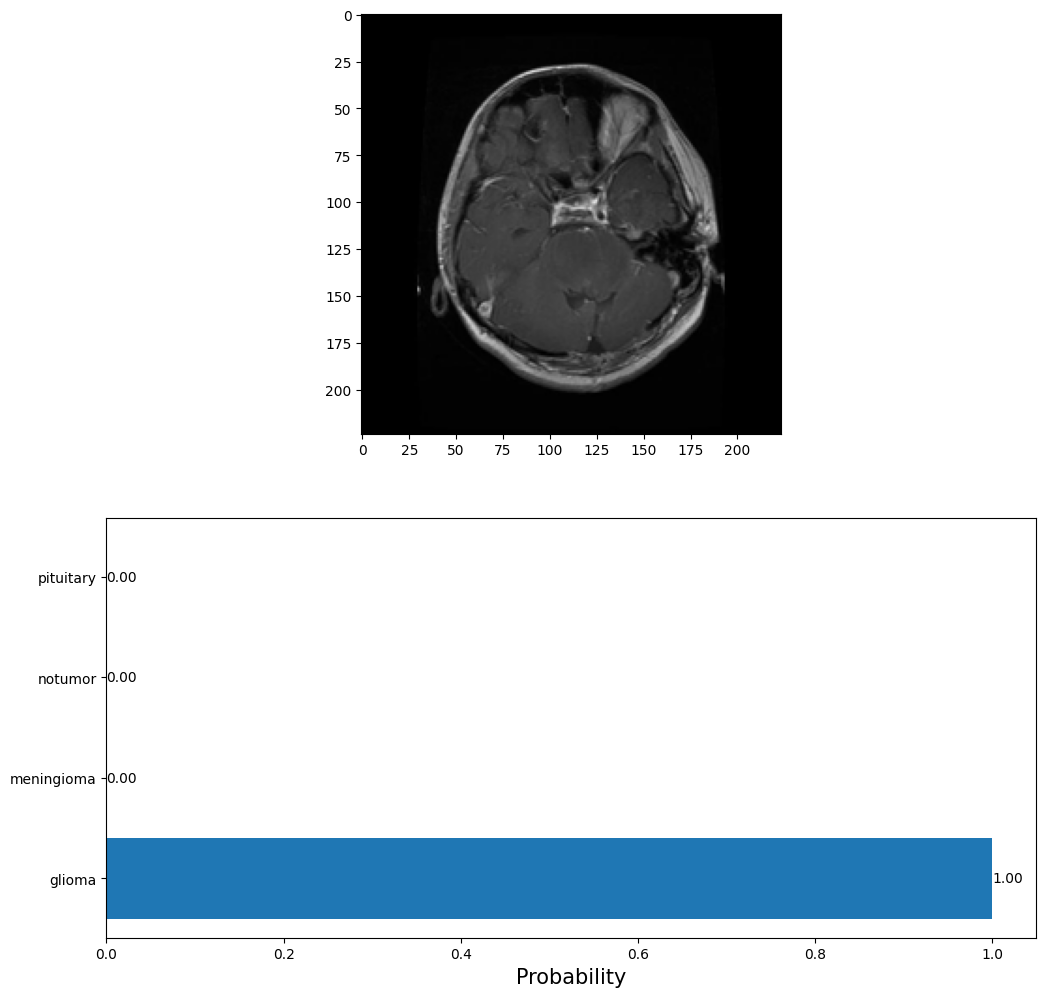

In [ ]:
predict('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0010.jpg')

164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


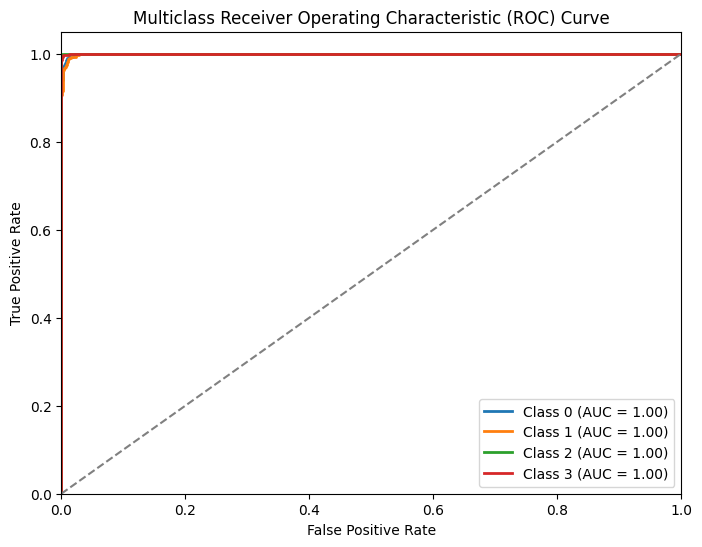

In [ ]:

from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_true_one_hot = to_categorical(y_true, num_classes=4)
plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf
model = tf.keras.models.load_model("mri2.h5")

y_true = gen_test.classes
y_pred_prob = model.predict(gen_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step
Accuracy: 0.9878
Precision: 0.9872
Recall: 0.9872
F1-Score: 0.9872


# VGG 19 test

In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

train_dir = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training"
test_dir = train_dir.replace("Training", "Testing")

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 80% train, 20% validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers[-5:]:
    layer.trainable = True
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1
)
model.save("brain_tumor_vgg19_finetuned.h5")
results = model.evaluate(test_generator)
test_loss, test_acc = results[:2]
print(f"Test Accuracy: {test_acc:.4f}")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.4729 - loss: 1.3945 - precision: 0.5095 - recall: 0.3751 - val_accuracy: 0.2796 - val_loss: 7.6908 - val_precision: 0.2796 - val_recall: 0.2796
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 711ms/step - accuracy: 0.5743 - loss: 0.9861 - precision: 0.6353 - recall: 0.4757 - val_accuracy: 0.2314 - val_loss: 20.3572 - val_precision: 0.2314 - val_recall: 0.2314
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 708ms/step - accuracy: 0.6490 - loss: 0.8643 - precision: 0.7020 - recall: 0.5596 - val_accuracy: 0.2358 - val_loss: 9.1173 - val_precision: 0.2362 - val_recall: 0.2358
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 707ms/step - accuracy: 0.6997 - loss: 0.7730 - precision: 0.7566 - recall: 0.6189 - val_accuracy: 0.3681 - val_loss: 2.1581 - val_precision: 0.3910 - val_recall: 0.3444
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 703ms/step - accuracy: 0.7285 - loss: 0.6939 - precision: 0.7763 - recall: 0.6679 - val_accuracy: 0.2

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.7330 - loss: 0.9523 - precision: 0.7403 - recall: 0.7245
Test Accuracy: 0.8551


In [ ]:
model.save("brain_tumor_vgg19_pretrained.h5")

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step
              precision    recall  f1-score   support

      glioma       1.00      0.59      0.74       300
  meningioma       0.78      0.82      0.80       306
     notumor       0.96      0.97      0.96       405
   pituitary       0.75      1.00      0.85       300

    accuracy                           0.86      1311
   macro avg       0.87      0.85      0.84      1311
weighted avg       0.88      0.86      0.85      1311

Accuracy: 0.8551
Precision: 0.8709
Recall: 0.8452
F1 Score: 0.8404


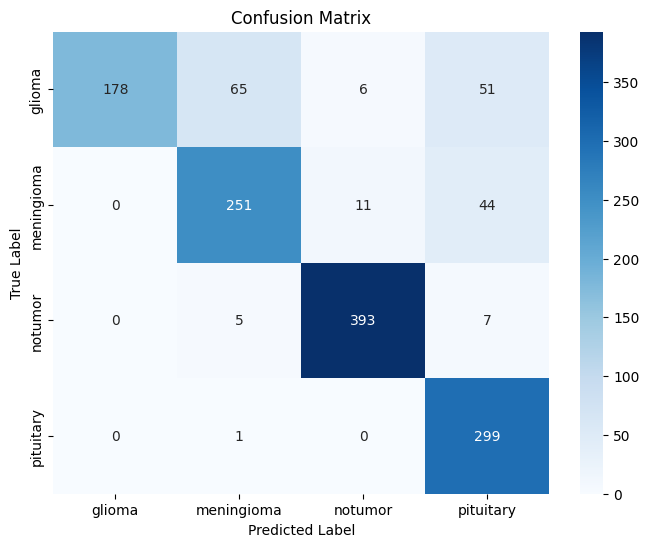

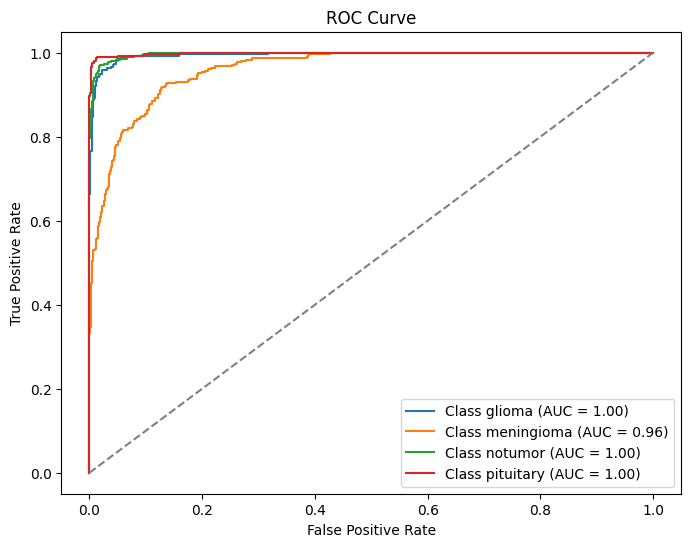

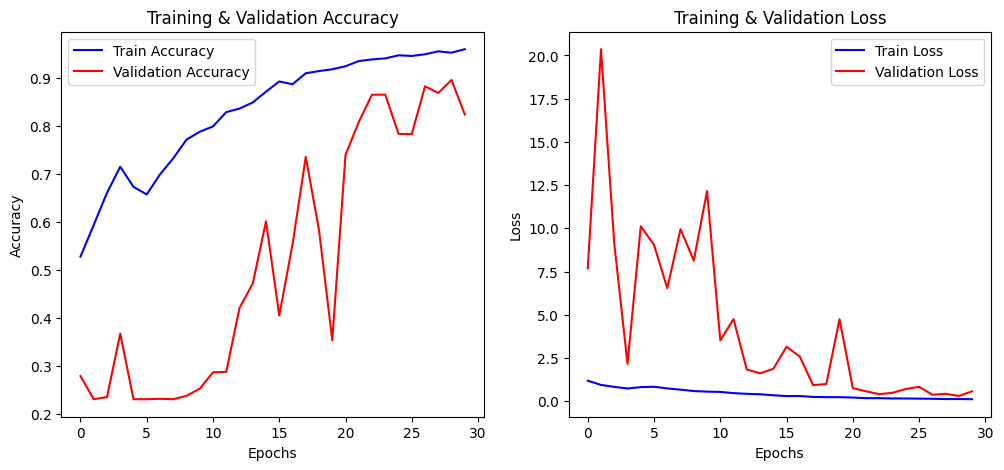

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model

model = load_model("brain_tumor_vgg19_pretrained.h5")
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

class_labels = list(test_generator.class_indices.keys())  # Class names
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()